<a href="https://colab.research.google.com/github/keethu12345/Tracing_PFAS_Source_Using_ML/blob/main/Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initially import the necessary tools and files required.

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.colors as colors
from itertools import combinations
from scipy.stats import spearmanr

saveDir = os.getcwd()

# Iteration tools
from itertools import combinations

# ---- Plotly Import ---- #
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Import necessary modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn import svm
from sklearn import tree
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile, chi2

# Import parallelization
from multiprocessing import Pool

# Import pickle to save the Knn models
import pickle
import joblib

# Import warnings to save warnings tool
import warnings
from pandas.errors import SettingWithCopyWarning

Import the necessary files, using the colab upload function.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving MLInput.xlsx to MLInput.xlsx
Saving LangbergData.xlsx to LangbergData.xlsx
Saving Input.xlsx to Input.xlsx


Load the data and remove all the NULL values from the dataset.

['PFAS source', 'Lake/stream', 'Species', 'Tissue', 'Categories', 'PFNA', 'PFDA', 'PFUnDA', 'PFDoDA', 'PFTrDA', 'PFTeDA', 'PFPeDA', 'L-PFOS', 'PFDS', 'FOSA', 'Sum LC-PFCA', 'Sum PFSA']


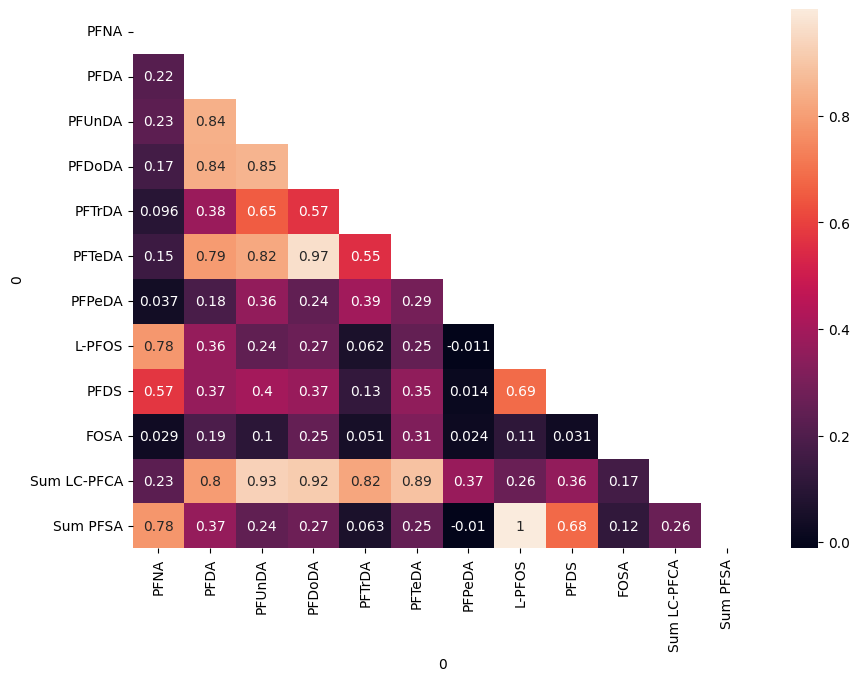

In [14]:
# Load data and remove 0/null values
lDf = pd. read_excel('LangbergData.xlsx')
lDf.columns = lDf.iloc[0]
cols = lDf.columns.to_list()
lDf = lDf.drop(0, axis = 0)
lDf = lDf.drop(lDf.columns[[0,1,4,5,7,9,10]], axis=1)
lDf = lDf.replace(to_replace='<', value=0, regex=True)
lDf = lDf.fillna(0)

col1 = 'Sum LC-PFCA'
col2 = 'Sum PFSA'
lDf[col1] = lDf[['PFHpA','PFOA','PFNA','PFDA','PFUnDA','PFDoDA','PFTrDA','PFTeDA','PFPeDA']].sum(axis=1)
# lDf[col1] = lDf['PFUnDA']
lDf[col2] = lDf[['PFHxS','PFHpS','L-PFOS','Br-PFOS','PFDS']].sum(axis=1)
with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
    # Create new dataframe
    df2 = lDf[lDf.columns.to_list()[0:4]]

    # Create the categorical data
    df2['PFAS source'] = pd.Categorical(df2['PFAS source'])
    df2['Categories']= df2['PFAS source'].cat.codes
    outDict = {}
    for i in lDf.columns.to_list()[5:len(lDf.columns)]:
        s = lDf[i]
        val = len(s[s > 0])/len(s)
        outDict[i] = val*100
        if val >= 0.10:
            df2[i] = list(s)

    # Create the numpy data
    features = df2.columns.to_list()[5:len(df2.columns)]
    features.extend(['Tissue-Codes'])
    X = df2[df2.columns.to_list()[5:len(df2.columns)]].to_numpy()
    y = df2['Categories'].to_numpy()

    # Display correlations matrix of data with more the 5% presence
    corrMatrix = df2[df2.columns.to_list()[5:len(df2.columns)]].corr()
    f, ax = plt.subplots(figsize=(10, 7))
    mask = np.triu(np.ones_like(df2[df2.columns.to_list()[5:len(df2.columns)]].corr()))
    ax = sns.heatmap(corrMatrix, annot=True, mask=mask)
plt.savefig('FeatureSelection\\CorrMat_greater5%.png', dpi =120)
# plt.show()
df2.head()
print(df2.columns.to_list())
outDf = pd.DataFrame([outDict]).T
outDf.reset_index(drop=False, inplace=True)
outDf.columns = ['Compounds', 'Percent Detect']

<ipython-input-15-7969f6c1537f>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outDf2, x='Compounds', y = 'Percent Detect', palette='husl', ax=ax)


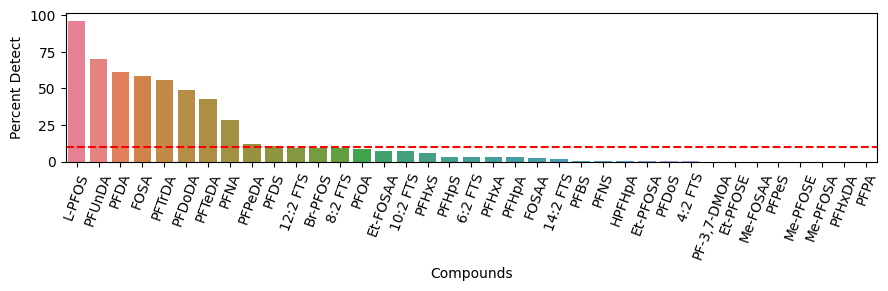

In [15]:
outDf = outDf.sort_values(by='Percent Detect',ascending=False)
outDf2 = outDf[~outDf['Compounds'].isin(['Sum PFSA', 'Sum LC-PFCA'])]
fig, ax = plt.subplots(1,1, figsize = (9,3))
sns.barplot(data=outDf2, x='Compounds', y = 'Percent Detect', palette='husl', ax=ax)
ax.tick_params('x', rotation = 70)
ax.plot([-1, len(outDf2.index)], [10,10], 'r--')
ax.set_xlim(-0.5, len(outDf2.index)-0.5)
plt.tight_layout()
plt.savefig('PercentDetect.png', dpi = 200)

In [16]:
plt.close()
outDf.to_excel('FeatureSelection\\cutoffData.xlsx')

In [17]:
def splitList(a, n):
    k, m = divmod(len(a), n)
    return (a[i*k+min(i, m):(i+1)*k+min(i+1, m)] for i in range(n))

In [18]:
def parrFunc(features, fCols, df3, totalK, totalR, cores):
    rDf = pd.DataFrame(columns=fCols)
    for f in list(set(combinations(features, i))):
        # initialize the data fram and everything else

        X = df3[list(f)].to_numpy()
        y = df3['Categories'].to_numpy()

        neighbors = np.arange(1, totalK+1)
        train_accuracy = np.empty(len(neighbors))
        test_accuracy = np.empty(len(neighbors))
        rs = np.arange(1,totalR+1)

        tests = np.zeros((totalK, totalR))
        trains = np.zeros((totalK, totalR))
        for j in rs:
            X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size = 0.40, random_state=j)
            for k, l in enumerate(neighbors):
                knn = KNeighborsClassifier(n_neighbors=l, weights='uniform')
                knn.fit(X_train, y_train)

                # Compute training and test data accuracy
                train_accuracy[k] = knn.score(X_train, y_train)
                test_accuracy[k] = knn.score(X_test, y_test)
            tests[:,j-1] = test_accuracy
            trains[:,j-1] = train_accuracy

        testAvg = np.nanmax(np.mean(tests, axis=1))
        trainAvg = np.nanmax(np.mean(trains, axis=1))


        dummy = pd.DataFrame([[list(f), i, round(testAvg,3), round(trainAvg,3), np.mean(tests, axis=1).argmax()+1]], columns=fCols)
        rDf = pd.concat([rDf, dummy], ignore_index=True)

    return rDf

In [19]:
# Set the number of neighbors and random states
totalK = 20
totalR = 2
fCols = ['features', 'n features','test accuracy', 'train accuracy','opt. k']
fDf = pd.DataFrame(columns=fCols)

# replace df3 data and convert to log for better fitting
df3 = df2
df3[df3.columns.to_list()[5:len(df3.columns)]] = np.log10(df3[df3.columns.to_list()[5:len(df3.columns)]].replace(0, 0.01).to_numpy())
df3['Tissue'] = pd.Categorical(df3['Tissue'])
df3['Tissue-Codes'] = df3['Tissue'].cat.codes
df3 = df3.dropna(axis='rows', how='any')
df3.to_excel('FeatureSelection\\Input.xlsx')
for i in list(range(1,14)):
    print(len(list(combinations(features,i))))

    rDf = parrFunc(features, fCols, df3, totalK, totalR, cores=4)
    fDf = pd.concat([fDf, rDf], ignore_index=True)


fDf.sample(5)

<ipython-input-19-08fc16e70d9a>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3[df3.columns.to_list()[5:len(df3.columns)]] = np.log10(df3[df3.columns.to_list()[5:len(df3.columns)]].replace(0, 0.01).to_numpy())
<ipython-input-19-08fc16e70d9a>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['Tissue'] = pd.Categorical(df3['Tissue'])
<ipython-input-19-08fc16e70d9a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

13
78
286
715
1287
1716
1716
1287
715
286
78
13
1


,features,n features,test accuracy,train accuracy,opt. k
7717,"[PFNA, PFDA, PFDoDA, PFTrDA, PFPeDA, L-PFOS, F...",9,0.922,1.000,1
2433,"[PFDA, PFUnDA, L-PFOS, FOSA, Sum LC-PFCA, Sum ...",6,0.909,1.000,1
899,"[PFDoDA, PFTeDA, PFPeDA, Sum LC-PFCA]",4,0.605,0.885,3
6945,"[PFNA, PFUnDA, PFDoDA, PFTeDA, PFPeDA, L-PFOS,...",8,0.885,0.999,1
820,"[PFTrDA, PFTeDA, PFDS, FOSA]",4,0.706,0.834,7


We shall be saving the data into a new file, namely realDataset_sorted_NEW. Representing the well pre-processed dataset.

In [29]:
# Saves the results from previous code block, don't run until the long code block is finished
fDf.sort_values(by=['test accuracy'], ascending=False).to_excel('realDataSet_sorted_NEW.xlsx')

<ipython-input-30-979d2eaa41ac>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=pltDf, x = "n features", y = "test accuracy", palette='turbo')


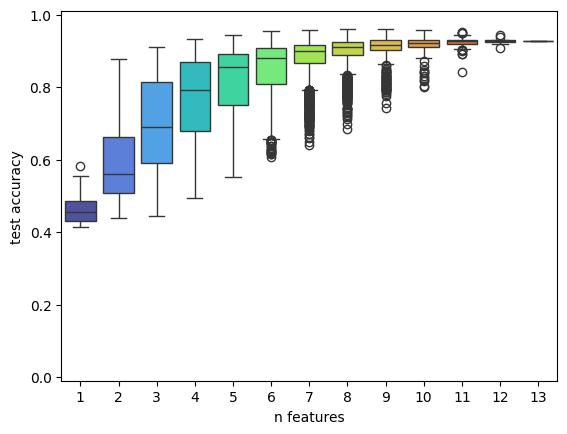

In [30]:
pltDf = pd.read_excel('realDataSet_sorted_NEW.xlsx')
sns.boxplot(data=pltDf, x = "n features", y = "test accuracy", palette='turbo')
plt.ylim(-0.01,1.01)
plt.savefig('FeatureSelection\\featureResults.png', dpi = 250, bbox_inches='tight')

Now, we shall be demonstrating the feature selection using the ski-kit learn.

In [31]:
lDf2 = lDf
X = lDf2[lDf2.columns.to_list()[5:len(lDf2.columns)]].to_numpy()
compNames = lDf2.columns.to_list()[5:len(lDf2.columns)]
lDf2['PFAS source'] = pd.Categorical(lDf2['PFAS source'])
lDf2['Categories']= lDf2['PFAS source'].cat.codes
y = lDf2['Categories'].to_numpy()

In [32]:
clf = SelectKBest(chi2, k=10).fit(X, y)
indicies = list(clf.get_feature_names_out())
indicies = [int(i.split('x')[1]) for i in indicies]
for i in indicies:
    print(compNames[i])

PFDA
PFUnDA
PFDoDA
PFTrDA
L-PFOS
Br-PFOS
FOSA
12:2 FTS
Sum LC-PFCA
Sum PFSA


In [33]:
clf.scores_

array([           nan, 7.21319552e+01, 3.70310007e+02, 2.12040598e+02,
       8.80831064e+01, 4.24969522e+03, 2.25701263e+03, 5.65610737e+03,
       6.77938811e+03, 1.86704427e+03, 1.74478803e+02,            nan,
       7.36763446e-01,            nan, 1.10340512e+02, 3.23698354e+02,
       3.74010553e+04, 1.96504711e+03, 5.73207418e-01, 3.72192080e+01,
       1.02983193e+00, 5.29692000e+03,            nan, 8.72368550e+00,
                  nan,            nan, 1.08832551e+02,            nan,
       1.37242984e+03, 1.01327801e+00, 4.90546069e+01, 6.48754387e+02,
       1.53637480e+03, 2.99884614e+03, 6.09877852e+01,            nan,
       1.79534034e+01, 1.33349368e+04, 3.83914955e+04])